In [8]:
# To use cleaning process if needed
from utils import *
from config_file import DOWNLOAD_ROOT, DATASETS_PATH, DOWNLOAD_URL, TWEETS_PATH

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from ggplot import *

import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.types import ArrayType

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "temporal_analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("nlp")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","16g")\
    .config("spark.debug.maxToStringFields","200")\
    .getOrCreate()

Saving figure happiness_avg_per_sec
Saving figure happiness_avg_per_min
Saving figure happiness_avg_per_hour


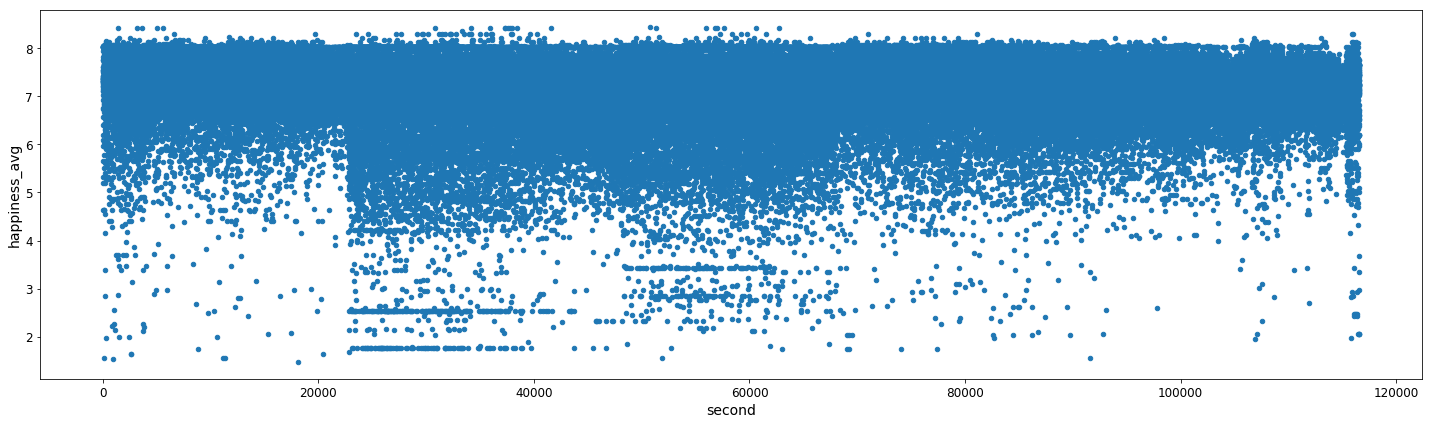

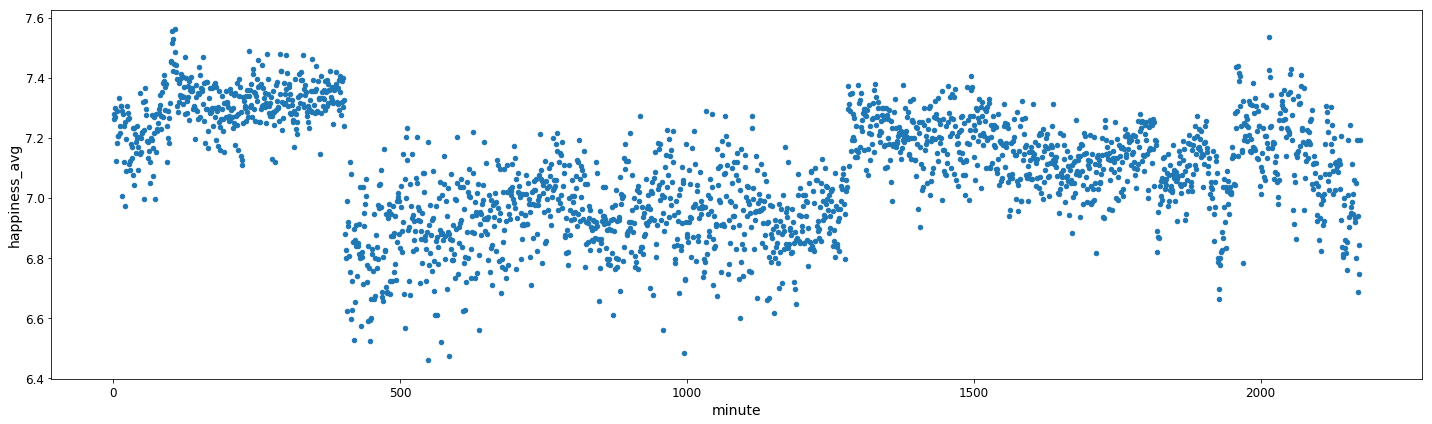

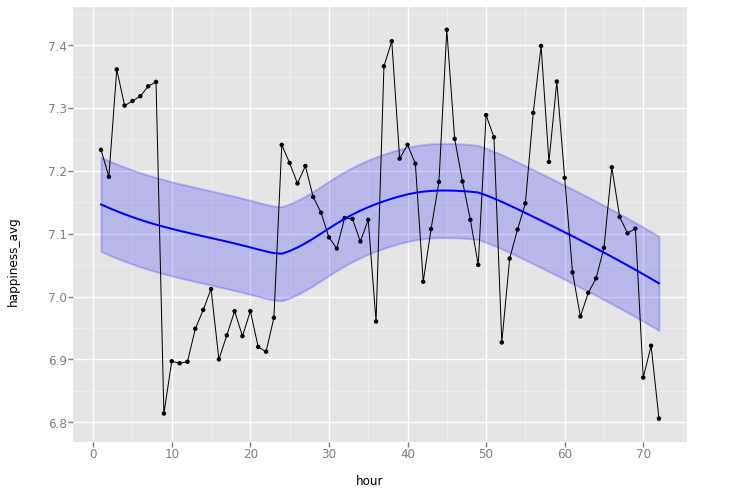

In [15]:
if __name__ == '__main__':
    tweets_happiness = spark.read.json('./datasets/tweets_happiness/tweets_happiness.json')
    tweets_happiness = tweets_happiness.withColumn('date' , regexp_replace('date', 't', ' '))
    tweets_happiness = tweets_happiness.withColumn('date' , regexp_replace('date', '\.', ' '))
    split_col = pyspark.sql.functions.split(tweets_happiness['date'], ' ')
    tweets_happiness = tweets_happiness.withColumn('time', split_col.getItem(1))
    tweets_happiness = tweets_happiness.withColumn('date', split_col.getItem(0))
    
    tweets_happiness = tweets_happiness.withColumn('hour_min',\
                                                   F.regexp_extract("time", pattern='(\d+):(\d+)', idx=0))
    tweets_happiness = tweets_happiness.withColumn('hour',\
                                                   F.regexp_extract("time", pattern='(\d+)', idx=0))
    tweets_happiness_min = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour_min")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min', 'hour')
    tweets_happiness_hour = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min','hour')

    tweets_happiness_second = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("time")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min','hour')
    
    tweets_happiness_second = avg_happiness_over_date(tweets_happiness_second, 'date', 'happiness_avg')
    tweets_happiness_min = avg_happiness_over_date(tweets_happiness_min, 'date', 'happiness_avg')
    tweets_happiness_hour = avg_happiness_over_date(tweets_happiness_hour, 'date', 'happiness_avg')

    tweets_happiness_second = tweets_happiness_second.sort('date')
    tweets_happiness_min = tweets_happiness_min.sort('date')
    tweets_happiness_hour = tweets_happiness_hour.sort('date')
    
    tweets_happiness_second.createOrReplaceTempView('tweets_happiness_second')
    tweets_second = spark.sql('select row_number() over (order by "date") as second, *\
                              from tweets_happiness_second')

    tweets_happiness_min.createOrReplaceTempView('tweets_happiness_min')
    tweets_min = spark.sql('select row_number() over (order by "date") as minute, *\
                            from tweets_happiness_min')

    tweets_happiness_hour.createOrReplaceTempView('tweets_happiness_hour')
    tweets_hour = spark.sql('select row_number() over (order by "date") as hour, *\
                            from tweets_happiness_hour')
    
    tweets_second = tweets_second.toPandas()
    tweets_min = tweets_min.toPandas()
    tweets_hour = tweets_hour.toPandas()
    
    ax = tweets_second.plot(kind="scatter", x="second", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_sec")
    
    ax = tweets_min.plot(kind="scatter", x="minute", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_min")
    
    ax = tweets_hour.plot(kind="line", x="hour", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_hour")

    
    filename = os.path.join(IMAGES_PATH, 'happiness_avg_minute_with_smooth.png' )
    p = ggplot(aes(x='minute', y='happiness_avg'), data=tweets_min)
    p+geom_point()+stat_smooth(color='blue', size = 2, method = 'loess')
    p.save(filename = filename)
    
    filename = os.path.join(IMAGES_PATH, 'happiness_avg_hour_with_smooth.png' )
    p = ggplot(aes(x='hour', y='happiness_avg'), data=tweets_hour)
    p+geom_point()+geom_line() + stat_smooth(color='blue', size = 2, method = 'loess' )
    p.save(filename = filename)